In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Get images from visual sensor

In [123]:
import sim as vrep
import time
import cv2
import numpy as np

vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    print ('Getting first image')
    
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    orientations = []
    images = []
    # Take p pictures
    p = 10
    i = 0
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        orientation = vrep.simxGetObjectOrientation(clientID, v1, -1, vrep.simx_opmode_blocking)[1][1]
        orientations.append(orientation)
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            images.append(img)
            # Show the images using Opencv (uncomment if you want to try it)
#             cv2.imshow('image',img)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(1)
        
    disp(orientations)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
[0.9467655420303345, 0.8196396231651306, 0.6790941953659058, 0.5253544449806213, 0.374274879693985, 0.2255346029996872, 0.07592088729143143, -0.07400863617658615, -0.2260320782661438, -0.3777500092983246, -0.530308723449707]


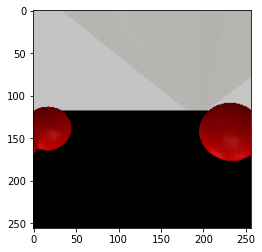

In [33]:
imshow(img)


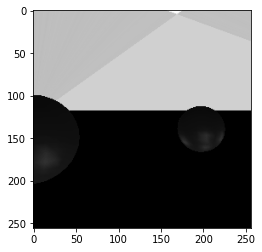

In [30]:
# Convert to gray scale
#IGNORE FOR GRADE

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray, cmap='gray')

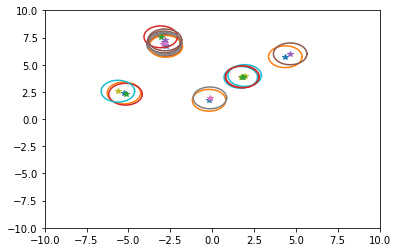

In [150]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

new_centers = []
circles_array = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)
    circles_array.append(circles)

i = -1
radii = []
for circles in circles_array:
    i = i + 1
    # for every circle we find it in our pov and plot it
    if circles is not None:
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # In pixels
            radius = circle[2]  # In pixels
            radii.append(radius)
            # Plot center
            u0, v0 = 132, 132
            k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
            fov = 60  # degrees

            # number of pixels in x-axis
            npx = 264

            # maximum value in the x-axis (in meters)
            xmax = npx / (2.* k)

            # Distance to the center of the sphere (z-axis coordinate)
            zc = xmax / tan(pi/6)

            # Location of the sphere in the x-axis coordinate
            xc = ((center[0] - u0) / k)
            
            # use a rotation matrix to rotate to our pov
            rotation_arr = np.array(((cos(orientations[i]), -sin(orientations[i])), (sin(orientations[i]), cos(orientations[i]))))
            xczc = np.array((xc, zc))
            new = rotation_arr.dot(xczc)
            
            # the new rotated values
            zc = new[1]
            xc = new[0]
            plot(xc, zc, '*')
            
            # plot the transformed circles
            s = linspace(0,2*pi,100)
            cx = cos(s) + xc
            cy = sin(s) + zc
            plot(cx, cy)
            new_centers.append([xc, zc])
            plt.axis((-10,10,-10,10))
            plt.grid()


In [151]:
#IGNORE FOR GRADE
u0, v0 = 132, 132


k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
fov = 60  # degrees

# number of pixels in x-axis
npx = 264

# maximum value in the x-axis (in meters)
xmax = npx / (2.* k)

# Distance to the center of the sphere (z-axis coordinate)
zc = xmax / tan(pi/6)
zc

# Location of the sphere in the x-axis coordinate
xc = (center[0] - u0) / k
xc

xc, zc

(2.122340425531915, 7.296724678694421)

### Grid representation

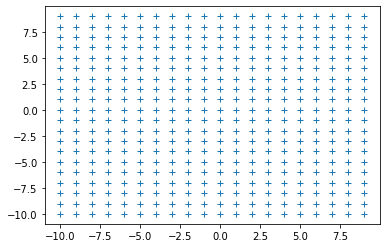

In [152]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

Draw each cell independently

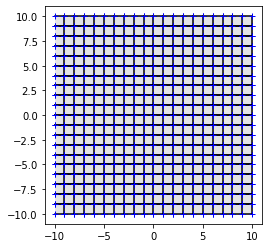

In [153]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

## Use the measurement

In [154]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n) # Initial belief

# For each cell, check if the circle is in it.
for i in range(n*n):
    x, y = grid_x[i], grid_y[i]
    #TODO Run this for each sphere (center and radius)
    # Corners of the cell
    X, Y = points_cell(x, y, cell_w)
    # do this for each circle we have
    for j in range(0, len(new_centers)):
        xc, zc = new_centers[j]
        # bring over the radii we calculated before
        radius = radii[j]
    # check based on the ecuclidean distance
        dist = sqrt((xc - X)**2 + (zc - Y)**2)
    
    # Check if At least one of the borders is within the sphere
        if((dist < radius/k).any()):
            print(dist)
            po = 0.8  # P(mi/zt) probability of having an obstacle 
            li = log(po / (1-po)) + gmap[i] - l0
            gmap[i] = li  # P(mi/zt) 
            print(li)
        else:
            po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle
        
        # Cells within the fov. Check if the four points are withing the FOV
            thetas = 2*pi
            if np.logical_and(-pi/6 <thetas, thetas < pi/6).all():
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li
           
            pass

# gmap

[2.22744684 1.58038535 0.83443716 1.77769146]
1.3862943611198908
[2.23619975 1.53123733 0.87664157 1.85051398]
2.3440172936683528
[2.07955161 1.60751179 0.67490471 1.48186946]
3.3017402262168147
[1.77769146 0.83443716 0.94601949 1.83271777]
1.3862943611198908
[1.85051398 0.87664157 1.09193092 1.96168669]
2.3440172936683528
[1.48186946 0.67490471 0.57175045 1.43782451]
3.3017402262168147
[1.83271777 0.94601949 1.75886907 2.3574397 ]
1.3862943611198908
[1.43782451 0.57175045 1.48266679 1.9846263 ]
2.3440172936683528
[1.58038535 1.42608426 0.48206206 0.83443716]
1.3862943611198908
[1.53123733 1.29953307 0.33555758 0.87664157]
2.3440172936683528
[1.60751179 1.68631355 0.84560961 0.67490471]
3.3017402262168147
[0.83443716 0.48206206 0.656545   0.94601949]
1.3862943611198908
[0.87664157 0.33555758 0.73240124 1.09193092]
2.3440172936683528
[0.67490471 0.84560961 0.76580535 0.57175045]
3.3017402262168147
[0.94601949 0.656545   1.62164079 1.75886907]
1.3862943611198908
[1.09193092 0.73240124 1.

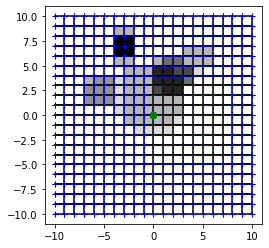

In [155]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()